In [2]:
import wandb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from dataset_class import CamVidDataset
from model_class import SegNet_Pretrained, DeepLabV3

In [3]:
config = dict(
    epochs=30,
    num_classes=32,
    learning_rate=0.001,
    batch_size=4,
    dataset="CamVid",
    architecture="SegNet",
    seed=2022028
)

In [4]:
def visualize_distribution(dataset, title, color):
    result = torch.zeros(32)
    for i in range(dataset.__len__()):
        _, tensor = dataset.__getitem__(i)
        flattened = tensor.flatten()
        counts = torch.bincount(flattened, minlength=32)
        result = result + counts
    distribution = result.tolist()
    distribution = [int(x) for x in distribution]
    df = pd.read_csv('CamVid/class_dict.csv')
    class_names = df['name'].to_list()

    print(f"{title}:")
    for name, count in zip(class_names, distribution):
        print(f"  {name}: {count}")


    keys = class_names
    values = distribution
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color=color, edgecolor='black')
    plt.xlabel("Class Names")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.show()
    return distribution

Training Data Distribution:
  Animal: 12045
  Archway: 119888
  Bicyclist: 1206357
  Bridge: 108089
  Building: 58191092
  Car: 7954394
  CartLuggagePram: 66140
  Child: 79955
  Column_Pole: 2641708
  Fence: 4264601
  LaneMkgsDriv: 4767634
  LaneMkgsNonDriv: 28591
  Misc_Text: 1673702
  MotorcycleScooter: 14074
  OtherMoving: 1196853
  ParkingBlock: 898329
  Pedestrian: 1579269
  Road: 72804272
  RoadShoulder: 620615
  Sidewalk: 17412636
  SignSymbol: 330974
  Sky: 38573748
  SUVPickupTruck: 1349654
  TrafficCone: 9874
  TrafficLight: 925123
  Train: 0
  Tree: 25820698
  Truck_Bus: 476318
  Tunnel: 4
  VegetationMisc: 2090713
  Void: 6693505
  Wall: 3141961


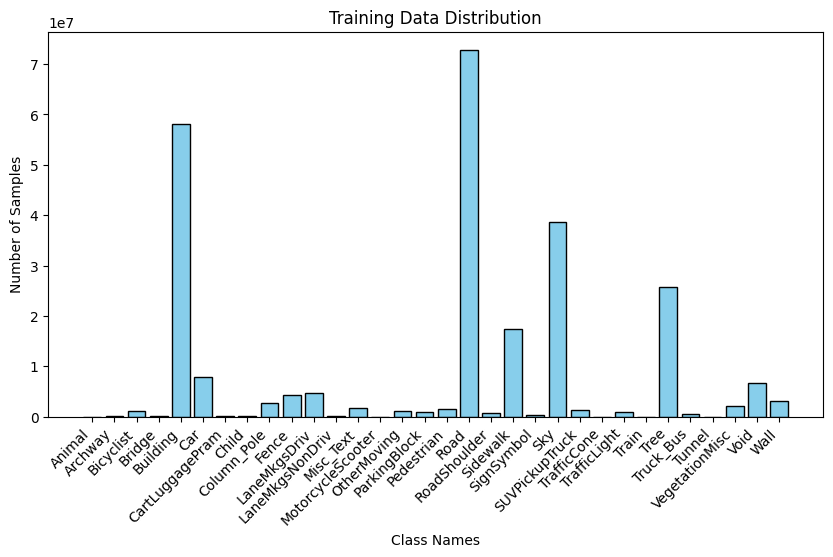

Test Data Distribution:
  Animal: 9402
  Archway: 33968
  Bicyclist: 1000137
  Bridge: 90470
  Building: 36615068
  Car: 6043741
  CartLuggagePram: 53306
  Child: 42074
  Column_Pole: 1452350
  Fence: 1779301
  LaneMkgsDriv: 2294790
  LaneMkgsNonDriv: 4308
  Misc_Text: 755379
  MotorcycleScooter: 30257
  OtherMoving: 483681
  ParkingBlock: 553125
  Pedestrian: 1097196
  Road: 39532700
  RoadShoulder: 340179
  Sidewalk: 9212977
  SignSymbol: 167219
  Sky: 27392256
  SUVPickupTruck: 1538591
  TrafficCone: 1581
  TrafficLight: 586715
  Train: 0
  Tree: 17685208
  Truck_Bus: 1835435
  Tunnel: 0
  VegetationMisc: 951959
  Void: 6198327
  Wall: 2576710


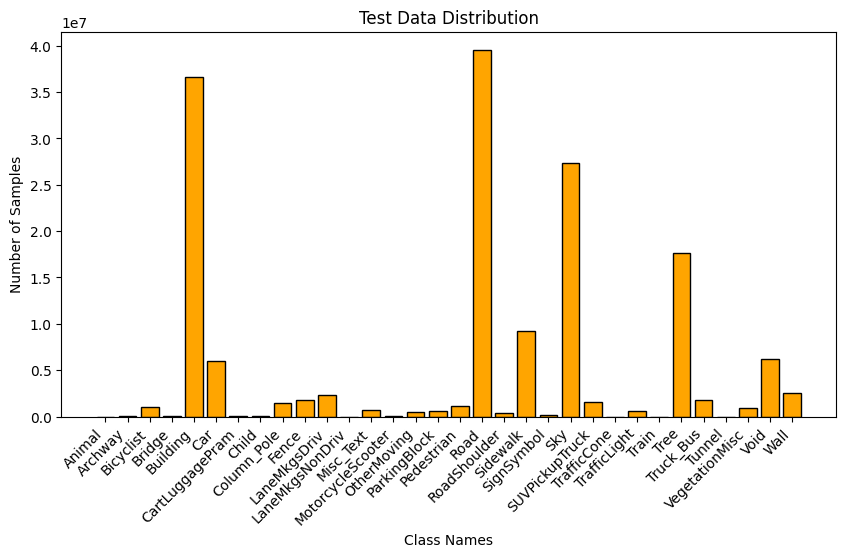

[9402,
 33968,
 1000137,
 90470,
 36615068,
 6043741,
 53306,
 42074,
 1452350,
 1779301,
 2294790,
 4308,
 755379,
 30257,
 483681,
 553125,
 1097196,
 39532700,
 340179,
 9212977,
 167219,
 27392256,
 1538591,
 1581,
 586715,
 0,
 17685208,
 1835435,
 0,
 951959,
 6198327,
 2576710]

In [6]:
train_dataset = CamVidDataset(img_dir='CamVid/train_images', label_dir='CamVid/train_labels', class_dict_dir='CamVid/class_dict.csv')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_dataset = CamVidDataset(img_dir='CamVid/test_images', label_dir='CamVid/test_labels', class_dict_dir='CamVid/class_dict.csv')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=True)

visualize_distribution(train_dataset, "Training Data Distribution", color='skyblue')
visualize_distribution(test_dataset, "Test Data Distribution", color='orange')

In [5]:
def train(train_dataloader, device, model, criterion, optimizer, weights_dir, config):
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        num_train_samples = 0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            # print(images.size())
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_batch_size = images.size(0)
            train_loss += loss.item() * curr_batch_size
            num_train_samples += curr_batch_size

        average_train_loss = train_loss/num_train_samples
        
        wandb.log({"epoch": epoch + 1, "train_loss": average_train_loss})
        print(f"EPOCH: {epoch+1} | TRAIN LOSS: {average_train_loss}")

        torch.save(model.state_dict(), weights_dir)
    print(f"weights saved at {weights_dir}")

In [6]:
def test(test_dataloader, device, weights_dir, num_classes):
    eval_dict = [{'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0} for _ in range(num_classes)]

    if weights_dir == 'decoder.pth':
        model = SegNet_Pretrained('encoder_model.pth', in_chn=3, out_chn=32).to(device)
    else:
        model = DeepLabV3().to(device)
    model.load_state_dict(torch.load(weights_dir))
    model.eval()

    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            for c in range(num_classes):
                eval_dict[c]['TP'] += ((pred == c) & (labels == c)).sum().item()
                eval_dict[c]['FP'] += ((pred == c) & (labels != c)).sum().item()
                eval_dict[c]['TN'] += ((pred != c) & (labels != c)).sum().item()
                eval_dict[c]['FN'] += ((pred != c) & (labels == c)).sum().item()

            correct_pixels += (pred == labels).sum().item()
            total_pixels += pred.numel()
    
    acc = correct_pixels / total_pixels

    class_wise_acc = []
    class_wise_IoU = []
    class_wise_dice_coef = []
    ep = 1e-9
    for metric in eval_dict:
        # print(metric['TP'], metric['TN'], metric['FP'], metric['FN'])
        class_acc = (metric['TP'] + metric['TN']) / (metric['TP'] + metric['TN'] + metric['FP'] + metric['FN'] + ep)
        class_dice_coef = 2*metric['TP']/ (2*metric['TP'] + metric['FP'] + metric['FN'] + ep)
        class_IoU = metric['TP']/ (metric['TP'] + metric['FP'] + metric['FN'] + ep)

        class_wise_acc.append(class_acc)
        class_wise_dice_coef.append(class_dice_coef)
        class_wise_IoU.append(round(class_IoU, 1))
    return acc, class_wise_acc, class_wise_IoU, class_wise_dice_coef



In [7]:
def plot_image(image, label, prediction):
    titles = ["Image", "Label", "Prediction"]
    tensors = [image, label, prediction]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        tensors[i] = tensors[i].cpu().squeeze(0).permute(1, 2, 0).numpy()
        axes[i].imshow(tensors[i])
        axes[i].axis("off")
        axes[i].set_title(titles[i])
    plt.show()

In [8]:
def get_color_masks(label, color_map, class_num, visualize):
    rgb_label = torch.zeros((1, 3, 360, 480), dtype=torch.uint8)

    for num, color in color_map.items():
        mask = label == num

        for ch in range(3):
            if visualize == 'focus' and num != class_num:
                rgb = (0, 0, 0)
            elif visualize == 'color' or num == class_num:
                rgb = color
            else:
                raise ValueError(f'visualize parameter only takes strings \'color\' or \'focus\' as input.')
            rgb_label[0, ch][mask] = rgb[ch]
    return rgb_label

In [9]:
def visualize_misclassified(test_dataloader, device, weights_dir, color_map, visualize):
    if weights_dir == 'decoder.pth':
        model = SegNet_Pretrained('encoder_model.pth', in_chn=3, out_chn=32).to(device)
        iou_classes = [2, 9, 31] # selected after seeing their IoU

    else:
        model = DeepLabV3().to(device)
        iou_classes = [2, 7, 10] # selected after seeing their IoU
    model.load_state_dict(torch.load(weights_dir))
    model.eval()

    with torch.no_grad():
        for c in iou_classes:
            print(f"Misclassifications in class {c}:")
            counter = 0
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)

                for i in range(preds.shape[0]):
                    TP = ((preds[i] == c) & (labels[i] == c)).sum().item()
                    FP = ((preds[i] == c) & (labels[i] != c)).sum().item()
                    FN = ((preds[i] != c) & (labels[i] == c)).sum().item()

                    IoU = TP / (TP + FP + FN + 1e-9)
                    if (IoU < 0.5 and IoU > 0):
                        prediction = get_color_masks(preds[i], color_map, c, visualize)
                        label = get_color_masks(labels[i], color_map, c, visualize)
                        # Add class index c to get_color_masks to obtain focused masks
                        plot_image(images[i], label, prediction)
                        counter += 1
                    
                    if counter == 3:
                        break

                if counter == 3:
                    break

In [10]:
def model_pipeline(weights_dir, config, is_train=False, is_test=False, visualize=False):
    project_name = 'SegNet' if weights_dir == 'decoder.pth' else 'DeepLabV3'
    wandb.login()
    with wandb.init(project=project_name, config=config):
        config = wandb.config

        random.seed(config.seed)
        np.random.seed(config.seed)
        torch.manual_seed(config.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(config.seed)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        transform = v2.Compose([
            v2.ConvertImageDtype(torch.float32),
            v2.Resize((360, 480)), 
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        target_transform = v2.Resize((360, 480), interpolation=InterpolationMode.NEAREST)

        train_dataset = CamVidDataset(img_dir='CamVid/train_images', label_dir='CamVid/train_labels', class_dict_dir='CamVid/class_dict.csv', transform=transform, target_transform=target_transform)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
        test_dataset = CamVidDataset(img_dir='CamVid/test_images', label_dir='CamVid/test_labels', class_dict_dir='CamVid/class_dict.csv', transform=transform, target_transform=target_transform)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True)

        if is_train:
            if weights_dir == 'decoder.pth':
                model = SegNet_Pretrained('encoder_model.pth', in_chn=3, out_chn=32).to(device)
            else:
                model = DeepLabV3().to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
            train(train_dataloader, device, model, criterion, optimizer, weights_dir, config) 

        if is_test:
            acc, class_wise_acc, class_wise_IoU, class_wise_dice_coef = test(test_dataloader, device, weights_dir, config.num_classes)
            print(f"miou: {sum(class_wise_IoU) / len(class_wise_IoU)}")
            for class_num in range(config.num_classes):
                print(f"class: {class_num} | pixel wise accuracy: {class_wise_acc[class_num]}")
            print("----------------------------------------------")
            for class_num in range(config.num_classes):
                print(f"class: {class_num} | IoU: {class_wise_IoU[class_num]}")
            print("----------------------------------------------")
            for class_num in range(config.num_classes):
                print(f"class: {class_num} | Dice Coefficient: {class_wise_dice_coef[class_num]}")
            print("----------------------------------------------")
            print(f"Overall Accuracy: {acc}")

        if visualize:
            df = pd.read_csv('CamVid/class_dict.csv')
            color_map = {index: (item['r'], item['g'], item['b']) for index, item in df.iterrows()}
            visualize_misclassified(test_dataloader, device, weights_dir, color_map, visualize)

In [ ]:
model_pipeline('decoder.pth', config, is_train=True, is_test=True)

EPOCH: 1 | TRAIN LOSS: 1.1019929802936057
EPOCH: 2 | TRAIN LOSS: 0.7877494420694269
EPOCH: 3 | TRAIN LOSS: 0.71139638968136
EPOCH: 4 | TRAIN LOSS: 0.6768139999197877
EPOCH: 5 | TRAIN LOSS: 0.6320224271520324
EPOCH: 6 | TRAIN LOSS: 0.605772049854631
EPOCH: 7 | TRAIN LOSS: 0.5725280697578969
EPOCH: 8 | TRAIN LOSS: 0.54274791803049
EPOCH: 9 | TRAIN LOSS: 0.5238154990517575
EPOCH: 10 | TRAIN LOSS: 0.49185527925905975
EPOCH: 11 | TRAIN LOSS: 0.4908998624786087
EPOCH: 12 | TRAIN LOSS: 0.4746903501774954
EPOCH: 13 | TRAIN LOSS: 0.45116540821998014
EPOCH: 14 | TRAIN LOSS: 0.43117923127568286
EPOCH: 15 | TRAIN LOSS: 0.42546726633673126
EPOCH: 16 | TRAIN LOSS: 0.4251659585405951
EPOCH: 17 | TRAIN LOSS: 0.39833541651782783
EPOCH: 18 | TRAIN LOSS: 0.39711768714630086
EPOCH: 19 | TRAIN LOSS: 0.3770119110527246
EPOCH: 20 | TRAIN LOSS: 0.3673727556091288
EPOCH: 21 | TRAIN LOSS: 0.35580188959189085
EPOCH: 22 | TRAIN LOSS: 0.3583182332956273
EPOCH: 23 | TRAIN LOSS: 0.3195191803185836
EPOCH: 24 | TRAIN 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0333505..2.64].


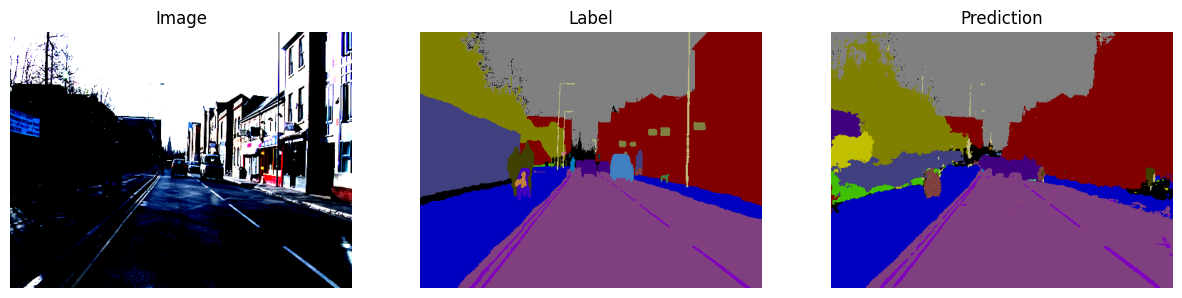

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0421805..2.64].


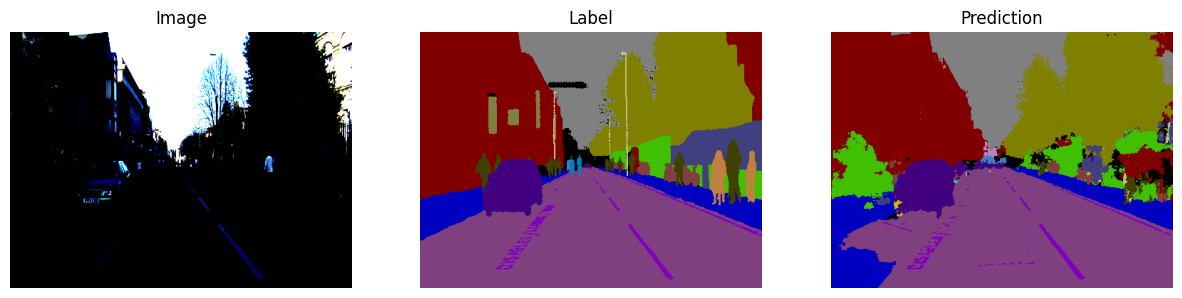

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0659945..2.64].


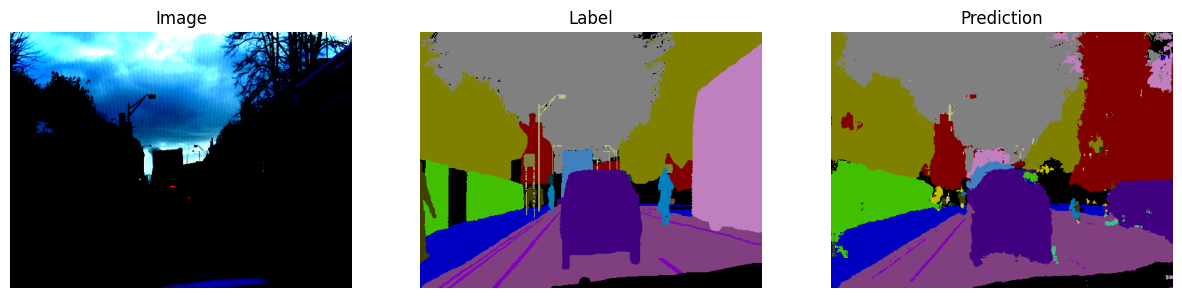

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9814411..2.64].


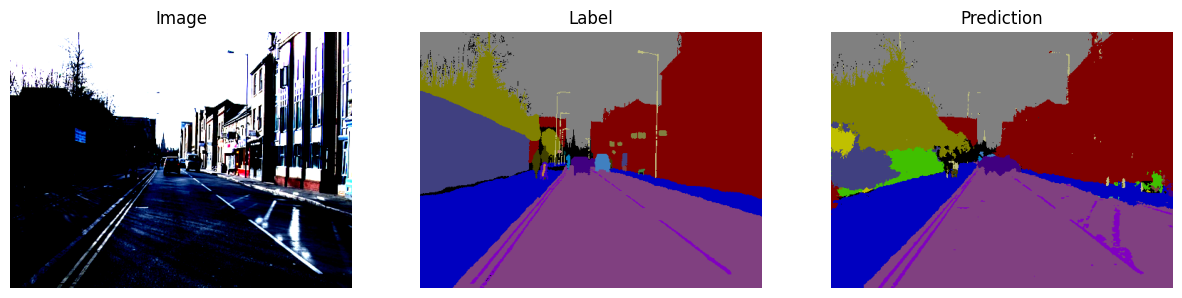

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0603755..2.5787258].


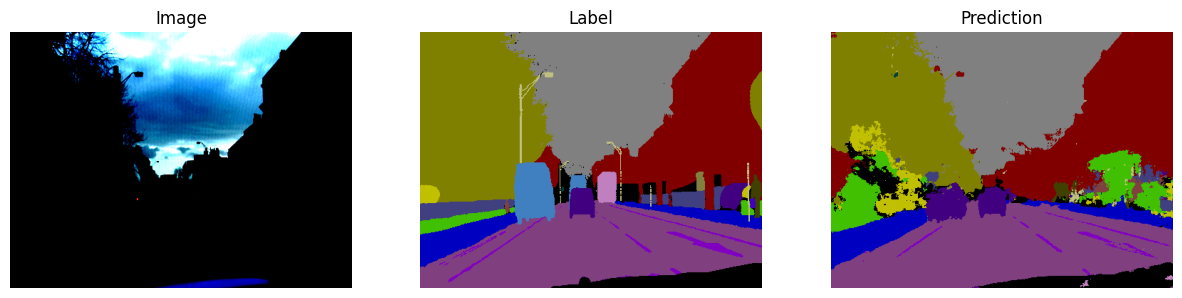

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.075092..2.64].


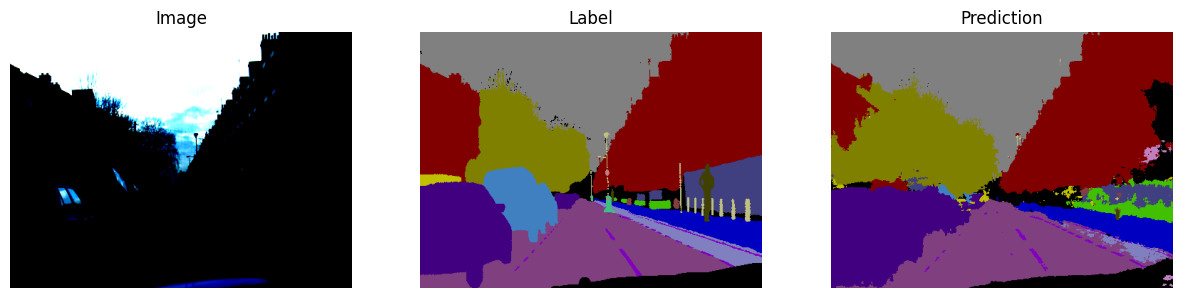

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.068135..2.64].


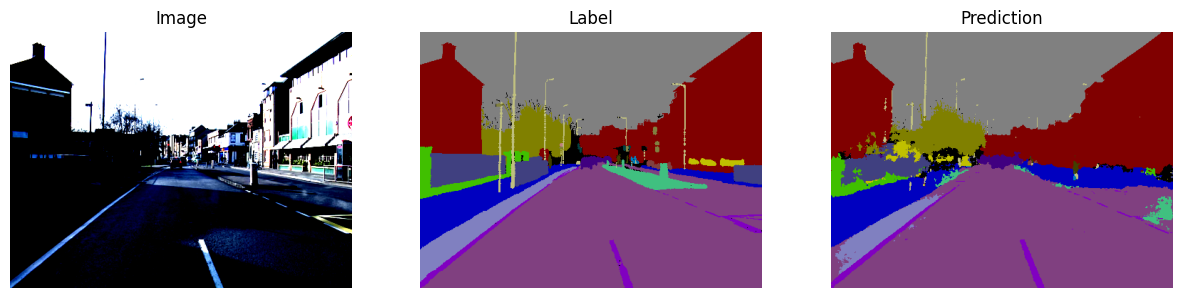

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1010468..2.64].


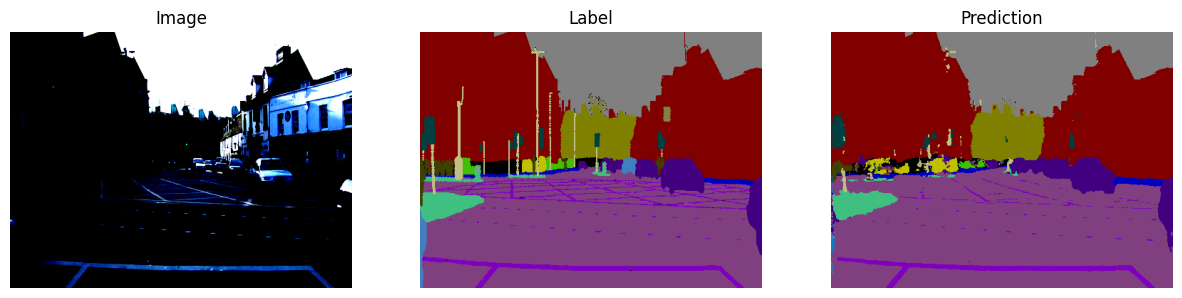

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0435183..2.64].


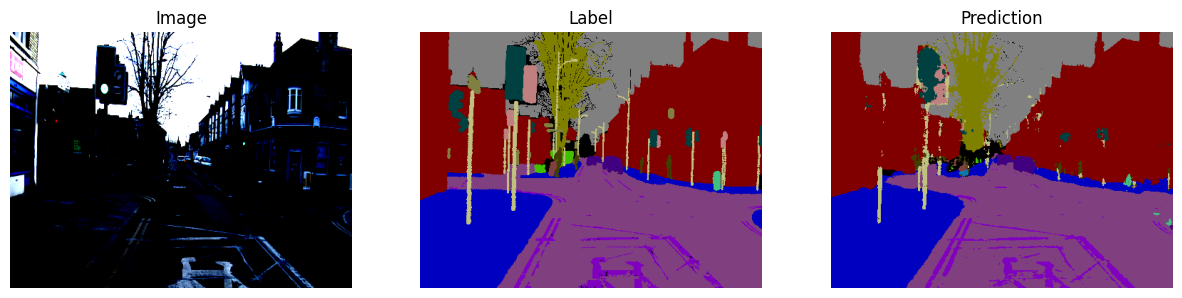

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0333505..2.64].


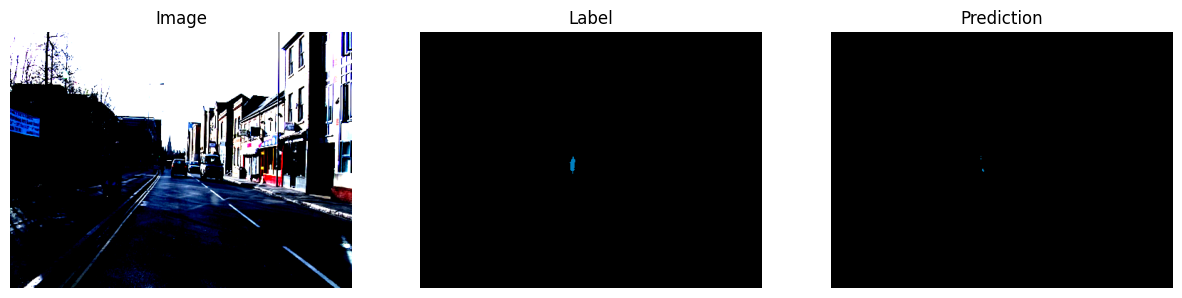

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0421805..2.64].


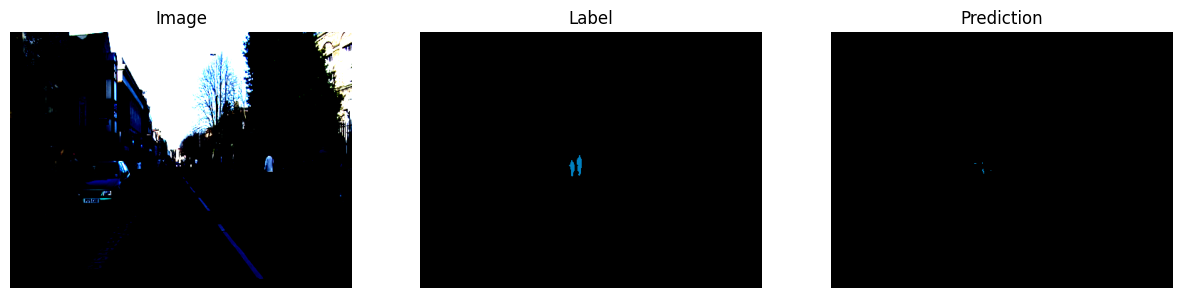

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0659945..2.64].


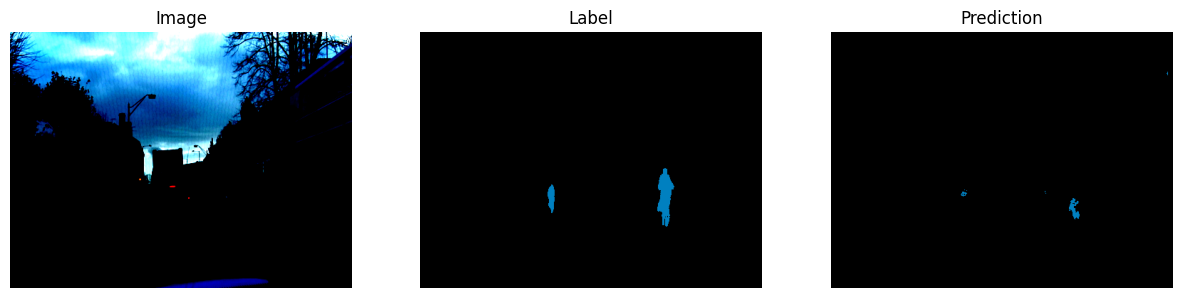

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9814411..2.64].


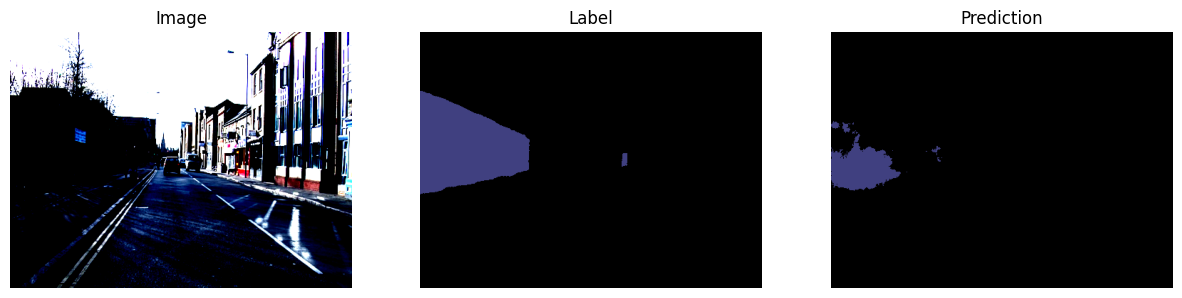

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0603755..2.5787258].


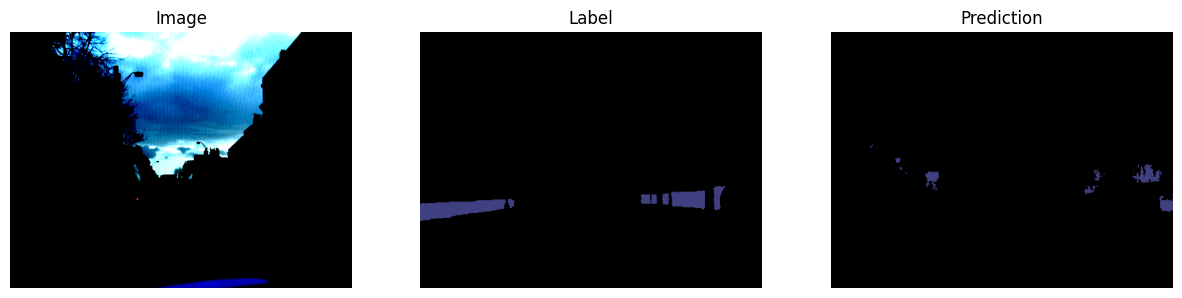

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.075092..2.64].


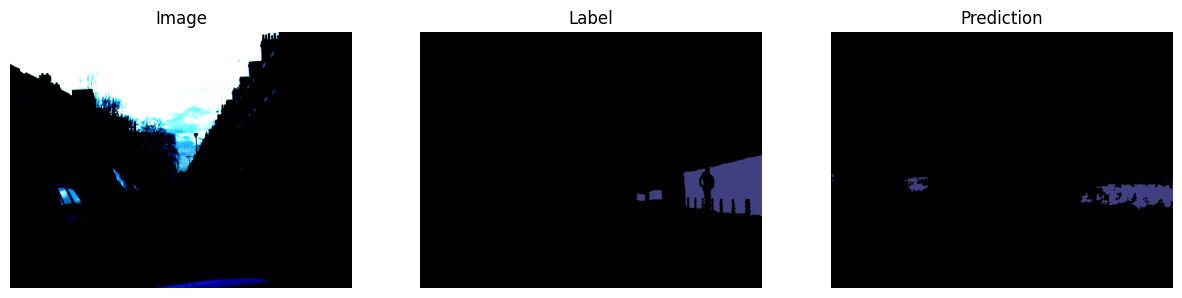

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.068135..2.64].


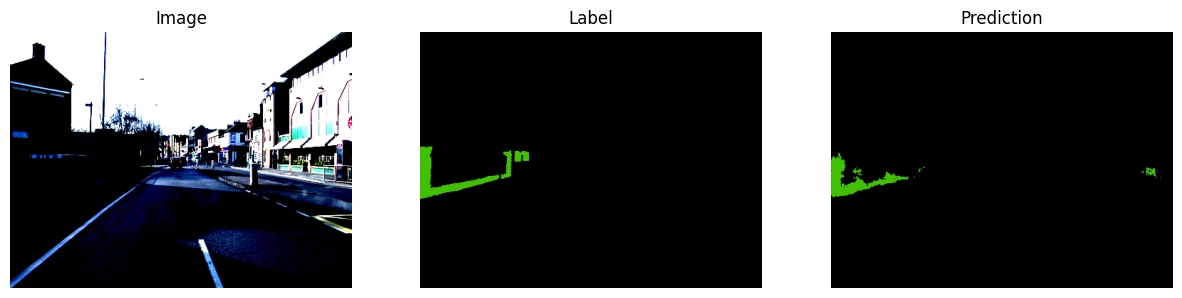

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1010468..2.64].


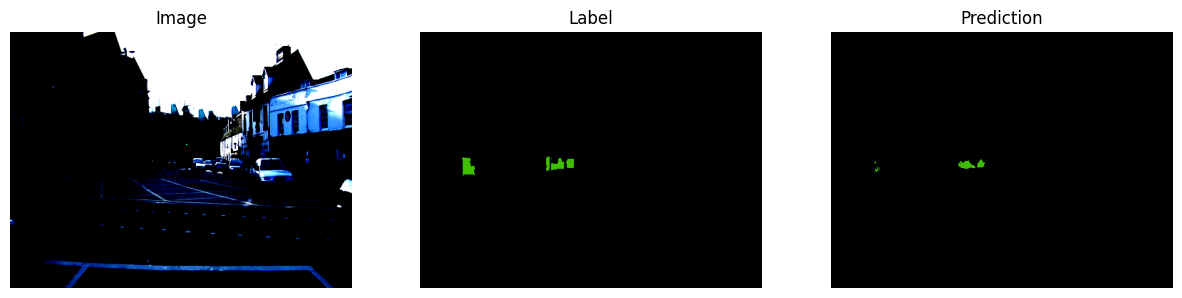

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0435183..2.64].


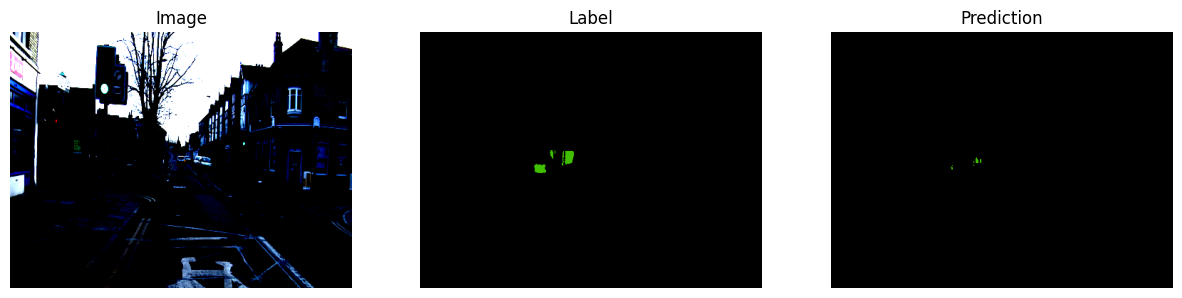

In [28]:
model_pipeline('decoder.pth', config, visualize='color')
model_pipeline('decoder.pth', config, visualize='focus')

In [11]:
model_pipeline('deeplabv3.pth', config, is_test=True)

wandb: Currently logged in as: aditya22028 (aditya22028-indraprastha-institute-of-information-techno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


miou: 0.36875
class: 0 | pixel wise accuracy: 0.999941555914751
class: 1 | pixel wise accuracy: 0.9997797683189655
class: 2 | pixel wise accuracy: 0.9962508481002554
class: 3 | pixel wise accuracy: 0.9991082974137931
class: 4 | pixel wise accuracy: 0.9575265405491699
class: 5 | pixel wise accuracy: 0.9908039242097701
class: 6 | pixel wise accuracy: 0.999647813896871
class: 7 | pixel wise accuracy: 0.999775303320562
class: 8 | pixel wise accuracy: 0.9904750858077905
class: 9 | pixel wise accuracy: 0.9930608935983397
class: 10 | pixel wise accuracy: 0.990082190892401
class: 11 | pixel wise accuracy: 0.9999726861829502
class: 12 | pixel wise accuracy: 0.9959261254789272
class: 13 | pixel wise accuracy: 0.9998120709610473
class: 14 | pixel wise accuracy: 0.9978514876676245
class: 15 | pixel wise accuracy: 0.997810928520115
class: 16 | pixel wise accuracy: 0.9929638858955939
class: 17 | pixel wise accuracy: 0.9776191331417624
class: 18 | pixel wise accuracy: 0.9986395224696679
class: 19 | p

In [12]:
model_pipeline('decoder.pth', config, is_test=True)

miou: 0.234375
class: 0 | pixel wise accuracy: 0.999941555914751
class: 1 | pixel wise accuracy: 0.9997877254948915
class: 2 | pixel wise accuracy: 0.9950717642480843
class: 3 | pixel wise accuracy: 0.9994346414032567
class: 4 | pixel wise accuracy: 0.9205309107598978
class: 5 | pixel wise accuracy: 0.9811573076309068
class: 6 | pixel wise accuracy: 0.9996670957056194
class: 7 | pixel wise accuracy: 0.999737812300447
class: 8 | pixel wise accuracy: 0.9904796505826947
class: 9 | pixel wise accuracy: 0.9890616269556194
class: 10 | pixel wise accuracy: 0.9919834570561942
class: 11 | pixel wise accuracy: 0.9999726861829502
class: 12 | pixel wise accuracy: 0.9949067588601532
class: 13 | pixel wise accuracy: 0.9998107988106641
class: 14 | pixel wise accuracy: 0.9957336566091954
class: 15 | pixel wise accuracy: 0.9947935125319285
class: 16 | pixel wise accuracy: 0.9915673890485313
class: 17 | pixel wise accuracy: 0.9710235322876756
class: 18 | pixel wise accuracy: 0.9979791766443167
class: 19

Misclassifications in class 2:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0469968..2.64].


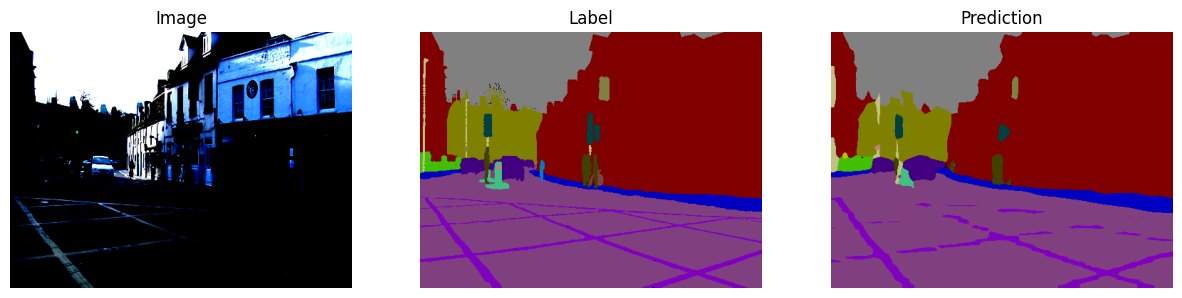

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0520806..2.64].


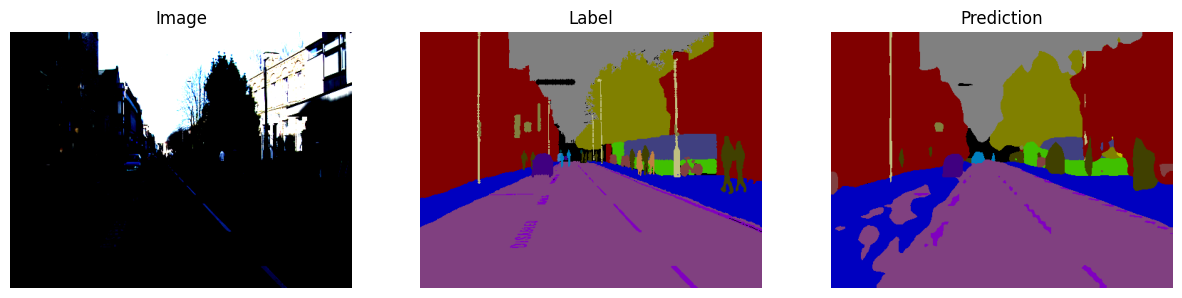

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.069473..2.64].


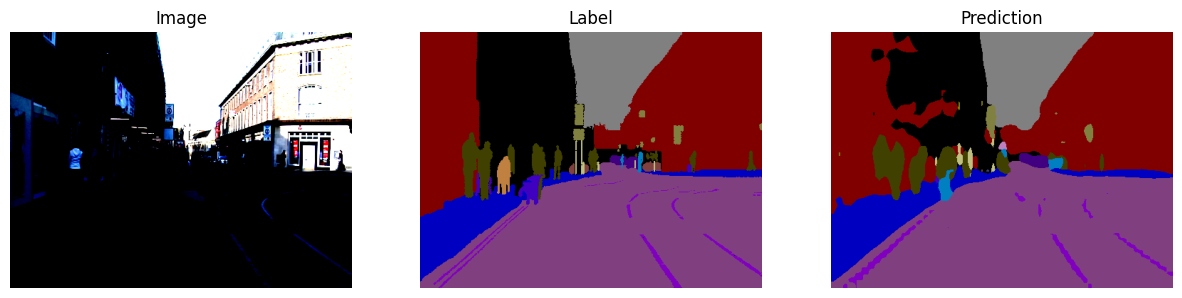

Misclassifications in class 7:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0900762..2.64].


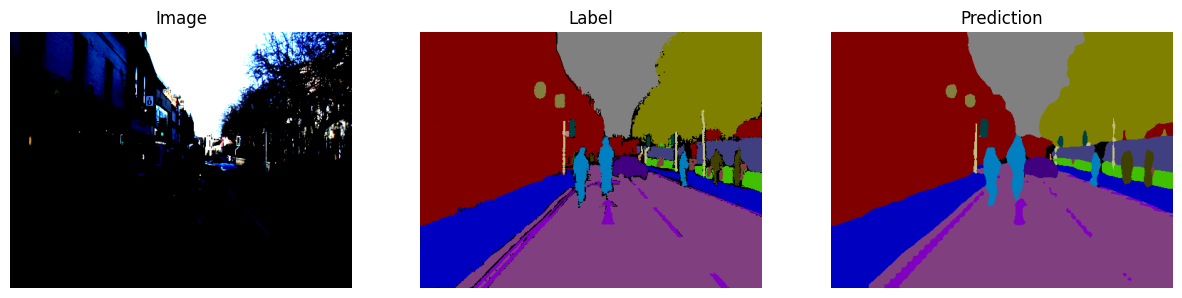

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0579674..2.64].


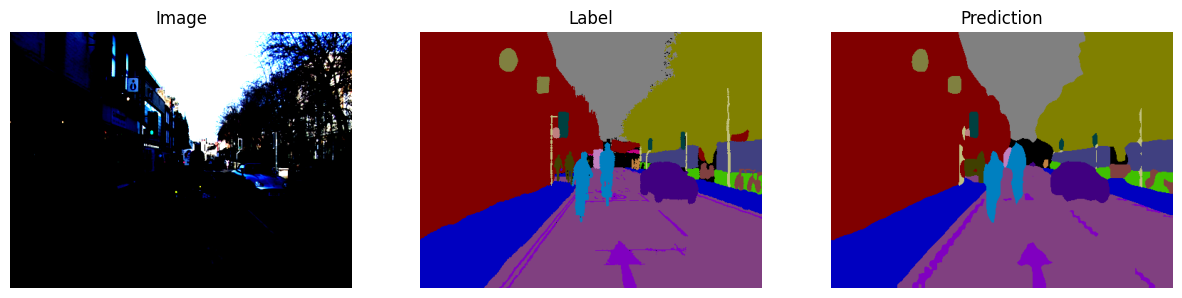

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0384345..2.64].


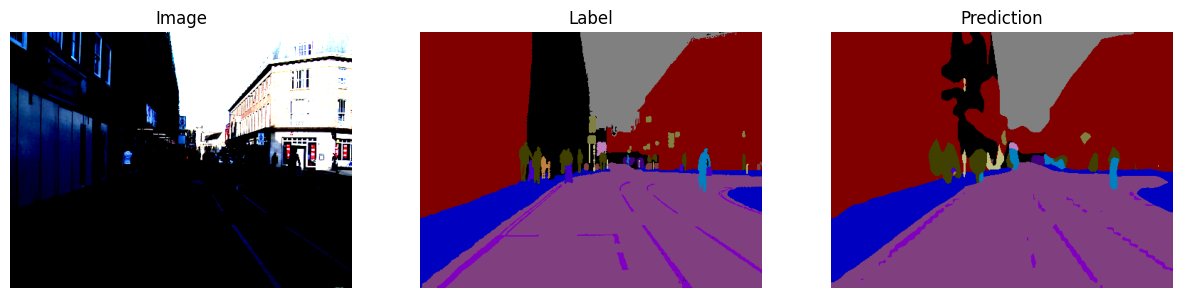

Misclassifications in class 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4787803].


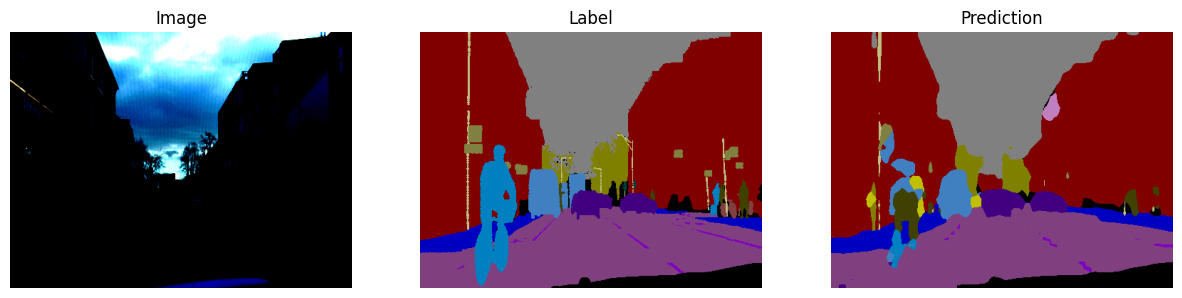

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0515456..2.64].


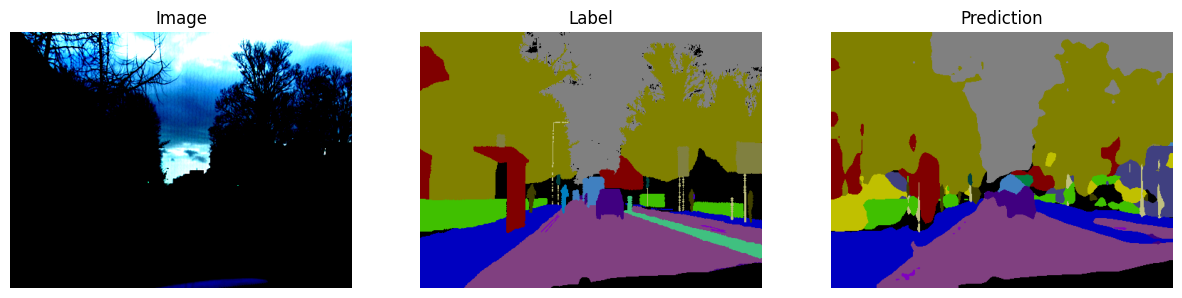

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9755545..2.64].


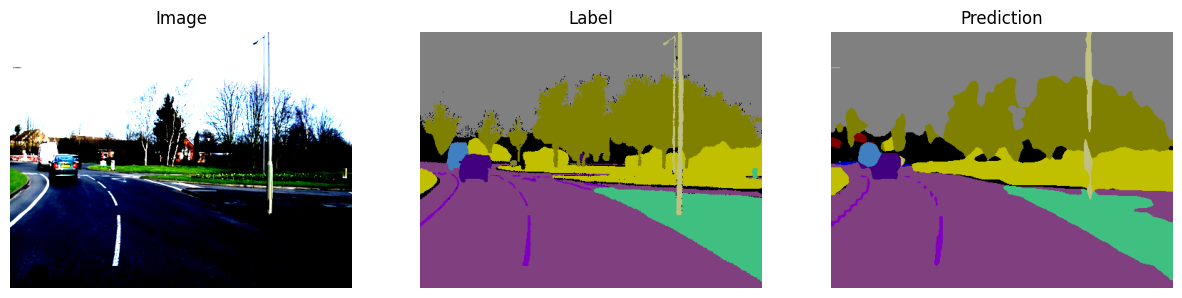

Misclassifications in class 2:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0469968..2.64].


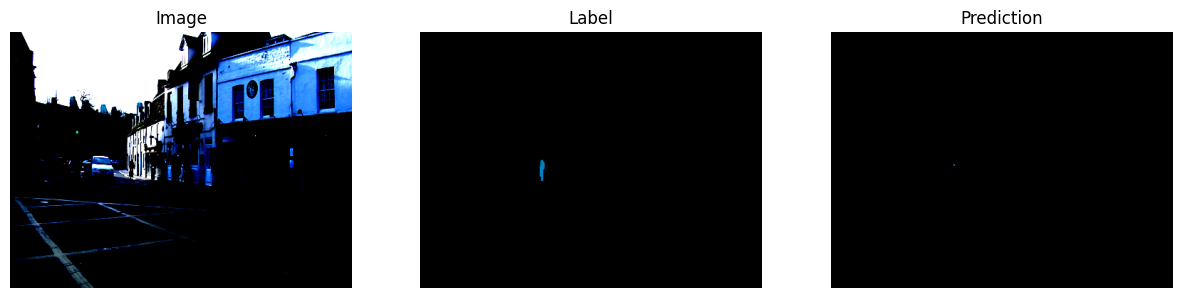

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0520806..2.64].


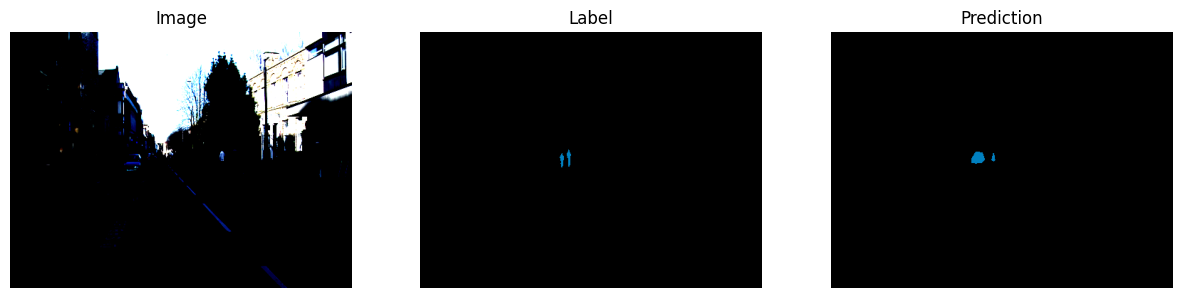

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.069473..2.64].


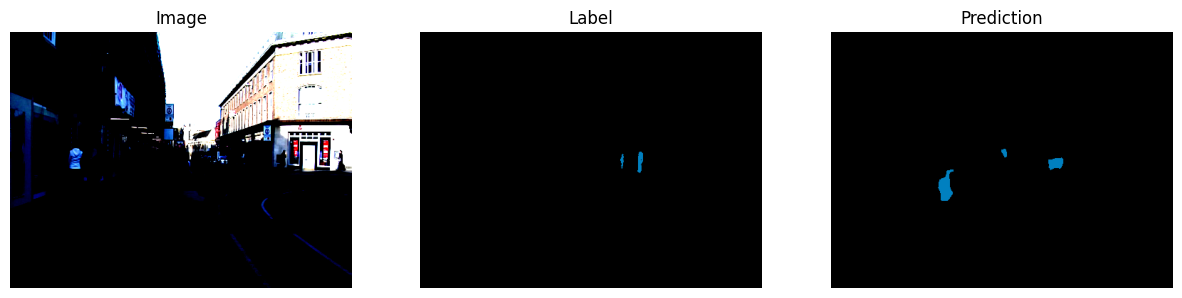

Misclassifications in class 7:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0900762..2.64].


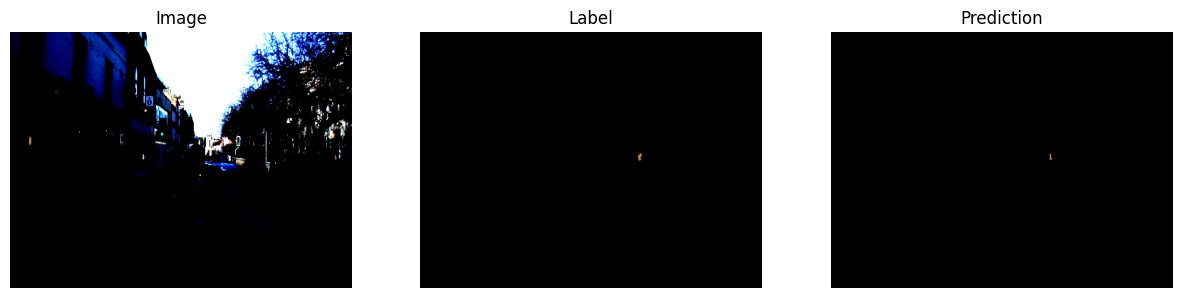

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0579674..2.64].


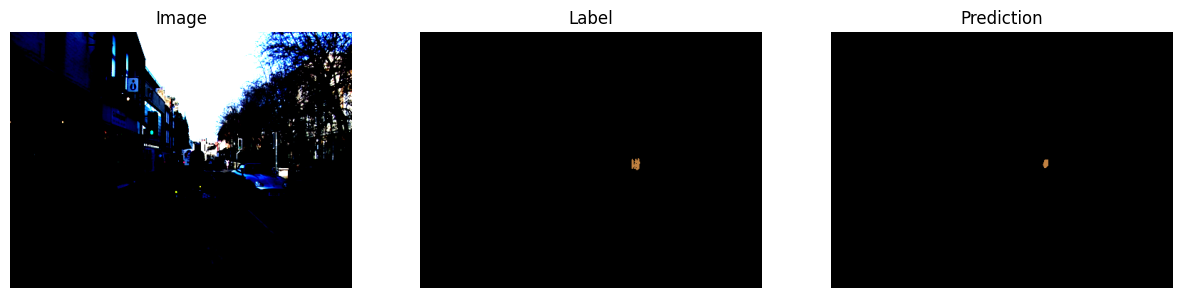

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0384345..2.64].


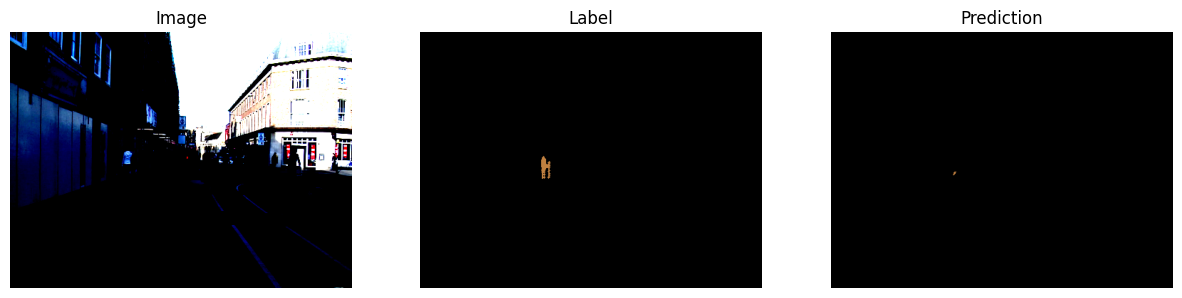

Misclassifications in class 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4787803].


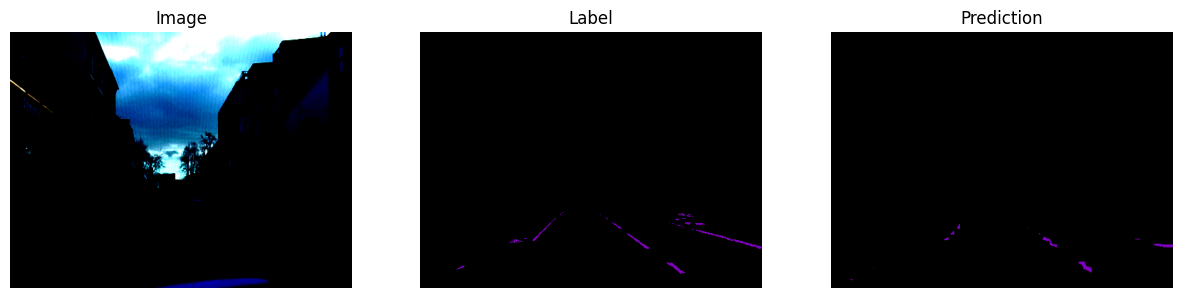

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0515456..2.64].


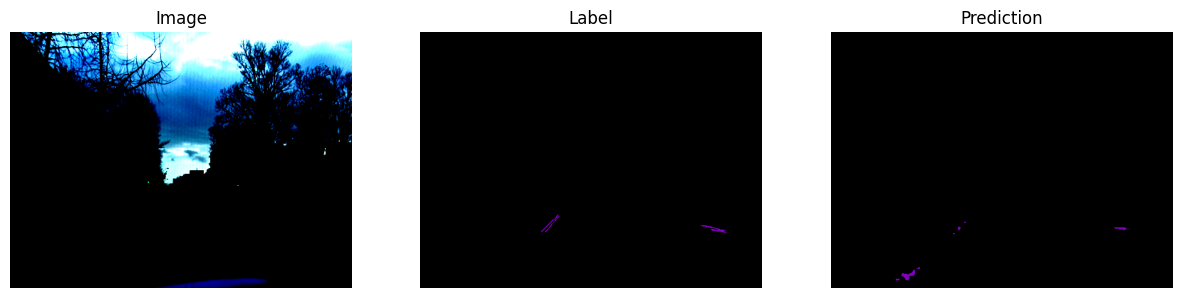

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9755545..2.64].


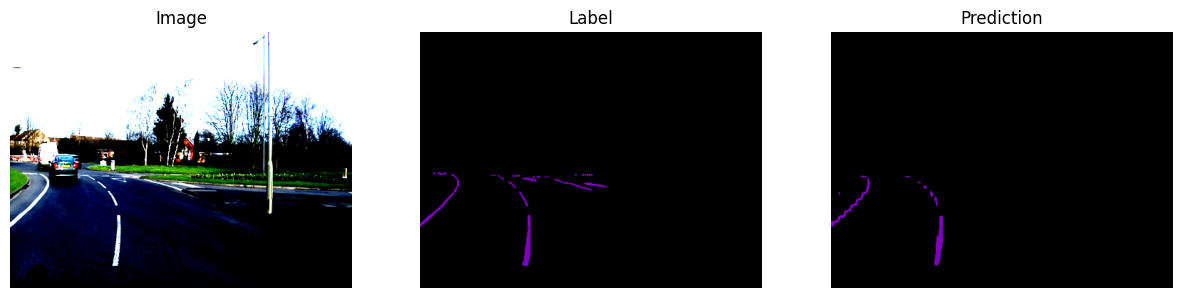

In [30]:
model_pipeline('deeplabv3.pth', config, visualize='color')
model_pipeline('deeplabv3.pth', config, visualize='focus')